[tensor(2.6941), tensor(3.9621), tensor(7.0929), tensor(4.9392), tensor(3.0060), tensor(9.0831), tensor(2.4896), tensor(3.2253), tensor(3.1595), tensor(3.1650), tensor(3.0045), tensor(4.2084), tensor(4.9492), tensor(0.2180), tensor(6.6041), tensor(2.8698), tensor(2.5025), tensor(5.6181), tensor(4.7291), tensor(3.3583), tensor(2.9780), tensor(3.4487), tensor(4.1549), tensor(4.6353), tensor(4.8174), tensor(2.3706), tensor(3.5672), tensor(3.5153), tensor(3.8304), tensor(8.4062), tensor(5.8252), tensor(6.0036), tensor(5.7325), tensor(2.3821), tensor(3.0960), tensor(4.2701), tensor(4.9106), tensor(3.6987), tensor(3.4630), tensor(2.7172), tensor(12.0344), tensor(2.7754), tensor(2.7467), tensor(3.2961), tensor(4.4028), tensor(2.1755), tensor(3.3162), tensor(3.5215), tensor(2.9892), tensor(2.5443), tensor(3.7411), tensor(4.3880), tensor(3.1752), tensor(3.0859), tensor(3.5000), tensor(4.3876), tensor(7.4913), tensor(2.8243), tensor(5.0054), tensor(4.0988), tensor(3.3010), tensor(4.6071), tensor

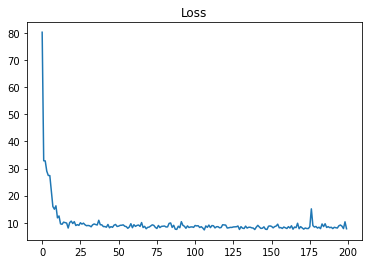

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE
from gmade import GMADE

random.seed(234) # 123
torch.manual_seed(234)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
        
class simpleRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, max_l=5, max_t=3):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size + max_l + max_t, hidden_size=hidden_size, nonlinearity='relu',
                          batch_first=True, num_layers=1)
        self.h_0 = nn.Parameter(torch.zeros((1, 1, hidden_size)))
        self.out_loc = nn.Linear(hidden_size, 1)
        self.out_std = nn.Linear(hidden_size, 1)
        self.max_l = max_l # max time steps
        self.max_t = max_t # type of random variables, ex. y1 y2 next_x
        self.softplus = nn.Softplus()
        
    def forward(self, x, obs, l, t):
        """
        x: x0
        obs: R
        l: length
        t: type, y1, y2 or next_x
        """
        length = l * 3
        input_x = x.repeat((int(length), 1))
        input_obs = obs.repeat((int(length), 1))
        input_l = []
        input_t = []
        
        for n in range(int(l)):
            
            for i in range(int(t)):
                input_l.append(n)
                input_t.append(i)
        input_l = F.one_hot(torch.tensor(input_l), self.max_l) 
        input_t = F.one_hot(torch.tensor(input_t), self.max_t) 
        
        input_ = torch.unsqueeze(torch.cat([input_x, input_obs, input_l, input_t], -1), 0)
        
        # the input is [x, obs, onehot(l), onehot(t)]
        rnn_output, _ = self.rnn(input_, self.h_0)
        rnn_output = torch.squeeze(rnn_output, 0)
        out_loc = self.out_loc(F.relu(rnn_output))
        out_std = self.softplus(self.out_std(F.relu(rnn_output)))
        # the first outputs are y_1_1, y_2_1, next_x_1; y_1_2, y_2_2, next_x_2
        return torch.squeeze(out_loc, 1), torch.squeeze(out_std, 1) # shape l * t

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 3
        self.max_rec = 5
        
        # for guide_0
        self.h_a_nn_0 = simpleNN(input_size=self.hidden_size, t="bern")
        self.h_b_nn_0 = simpleNN(input_size=self.hidden_size)
        self.h_encoder_0 = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_0 = nn.Parameter(torch.zeros(self.hidden_size))
        
        
        # for guide_1
        self.h_a_nn_1 = simpleNN(input_size=1 + self.hidden_size, t="bern")
        self.h_b_nn_1 = simpleNN(input_size=1 + self.hidden_size)
        self.h_encoder_1 = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_1 = nn.Parameter(torch.zeros(self.hidden_size))
        
        # for guide_2
        self.h_a_nn_2 = simpleNN(input_size=1 + self.hidden_size, t="bern")
        self.h_b_nn_2 = simpleNN(input_size=2 + self.hidden_size)
        self.h_encoder_2 = simpleNN(input_size=2 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_2 = nn.Parameter(torch.zeros(self.hidden_size))
        
        # for guide_made_0
        self.hidden_size_made_0 = 3
        self.made_in_dim_0_1 = 1 + self.hidden_size_made_0
        self.num_var_0_1 = 1
        self.made_out_dim_0_1 = self.made_in_dim_0_1 * self.num_var_0_1
        self.made_hidden_0_1 = [32, 32]
        self.made_0_1 = MADE(self.made_in_dim_0_1, self.made_hidden_0_1, self.made_out_dim_0_1, num_masks=1, natural_ordering=True)
        self.made_map_a_0 = nn.Linear(self.made_out_dim_0_1, 1)
    
        self.made_in_dim_0_2 = 2 + self.hidden_size_made_0
        self.num_var_0_2 = 1
        self.made_out_dim_0_2 = self.made_in_dim_0_2 * self.num_var_0_2
        self.made_hidden_0_2 = [32, 32]
        self.made_0_2 = MADE(self.made_in_dim_0_2, self.made_hidden_0_2, self.made_out_dim_0_2, num_masks=1, natural_ordering=True)
        self.made_map_b_loc_0 = nn.Linear(self.made_out_dim_0_2, 1)
        self.made_map_b_std_0 = nn.Linear(self.made_out_dim_0_2, 1)
        self.h_encoder_made_0 = simpleNN(input_size=2 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_made_0 = nn.Parameter(torch.zeros(self.hidden_size_made_0))
        
        self.softplus = nn.Softplus()
        
        # for guide_gmade
        input_dim_dict1 = {
            "obs" : 1,
            "h" : self.hidden_size,
        }
        var_dim_dict1 = {
            "a" : 1,
        }
        
        dependency_dict1 = {
            "a" : ["h", "obs"],
        }
        
        dist_type_dict1 = {
            "a" : "bern"
        }
        
        
        self.gmade1 = GMADE(input_dim_dict1, dependency_dict1, var_dim_dict1, dist_type_dict1)
        
        input_dim_dict2 = {
            "obs" : 1,
            "h" : self.hidden_size,
            "a" : 1
        }
        var_dim_dict2 = {
            "b" : 1,
        }
        
        dependency_dict2 = {
            "b" : ["h", "obs", "a"],
        }
        self.gmade2 = GMADE(input_dim_dict2, dependency_dict2, var_dim_dict2)
        
        self.h_encoder_gmade = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_gmade = nn.Parameter(torch.zeros(self.hidden_size))

    
    def g(self, x):
        return torch.tanh(x) 
    
    def model(self, obs):
        pyro.module("model", self)
        def rec_model(prefix, l):
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(0.5))
            if a > 0 or l > self.max_rec:
                b = pyro.sample("b_{}".format(prefix), dist.Normal(0, 1))
                return b
            else:
                c = rec_model(prefix+"c", l + 1)
                d = rec_model(prefix+"d", l + 1)
                return c + d
        sig = torch.tensor(0.5)
        x = rec_model("root", 0)
        pyro.sample("obs", dist.Normal(x, sig), obs=float(obs))
    
    # guide uses simple and individual NN for each random variable
    def guide_0(self, obs):
        pyro.module("model", self)
        def rec_guide(prefix, h, l):
            a_prob = self.h_a_nn_0([h])
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(a_prob))
            if a > 0 or l > self.max_rec:
                b_loc, b_std = self.h_b_nn_0([h])
                return pyro.sample("b_{}".format(prefix), dist.Normal(b_loc, b_std))
            else:
                c = rec_guide(prefix+"c", h, l + 1)
                h = self.h_encoder_0([c,h])
                d = rec_guide(prefix+"d", h, l + 1)
                return c + d 
        rec_guide("root", self.h0_0, 0)
                
    
    # guide uses simple and individual NN for each random variable, add obs as dependency
    def guide_1(self, obs):
        pyro.module("model", self)
        def rec_guide(prefix, h, obs, l):
            a_prob = self.h_a_nn_1([h, obs])
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(a_prob))
            if a > 0 or l > self.max_rec:
                b_loc, b_std = self.h_b_nn_1([h, obs])
                return pyro.sample("b_{}".format(prefix), dist.Normal(b_loc, b_std))
            else:
                c = rec_guide(prefix+"c", h, obs, l + 1)
                h = self.h_encoder_1([c,h])
                d = rec_guide(prefix+"d", h, obs, l + 1)
                return c + d 
        rec_guide("root", self.h0_1, obs, 0)
        
    # guide uses simple and individual NN for each random variable, more dependency considered
    def guide_2(self, obs):
        pyro.module("model", self)
        def rec_guide(prefix, h, obs, l):
            a_prob = self.h_a_nn_2([h, obs])
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(a_prob))
            if a > 0 or l > self.max_rec:
                #b_loc, b_std = self.h_b_nn_2([h, obs, a_prob])
                b_loc, b_std = self.h_b_nn_2([h, obs, a])
                #b_loc, b_std = self.h_b_nn_2([h, obs, torch.tensor(0)])
                return pyro.sample("b_{}".format(prefix), dist.Normal(b_loc, b_std))
            else:
                c = rec_guide(prefix+"c", h, obs, l + 1)
                #h = self.h_encoder_2([c,h,a])
                h = self.h_encoder_2([c,h,torch.tensor(0)]) 
                d = rec_guide(prefix+"d", h, obs, l + 1)
                return c + d 
        rec_guide("root", self.h0_2, obs, 0)
    
    # guide uses simple and individual NN for each random variable, more dependency considered
    def guide_gmade(self, obs):
        pyro.module("model", self)
        def rec_guide(prefix, h, obs, l):
            input_made_1 = {
                "h" : h,
                "obs" : obs
            }
            output_a = self.gmade1(input_made_1, suffix="_{}".format(prefix))
            a = output_a["a"]
            if a > 0 or l > self.max_rec:
                input_made_2 = {
                    "h" : h,
                    "obs" : obs,
                    "a" : a
                }
                output_b = self.gmade2(input_made_2, suffix="_{}".format(prefix))
                return output_b["b"]
            else:
                c = rec_guide(prefix+"c", h, obs, l + 1)
                h = self.h_encoder_gmade([c,h,torch.tensor(0)]) 
                d = rec_guide(prefix+"d", h, obs, l + 1)
                return c + d 
        rec_guide("root", self.h0_gmade, obs, 0)
        
    def guide_made_0(self, obs):
        pyro.module("model", self)
        def concat_input_made(x_list):
            for i in range(len(x_list)):
                if x_list[i].dim() == 0:
                    x_list[i] = torch.unsqueeze(x_list[i], dim=0)
            input_x = torch.cat(x_list)
            return input_x
        def rec_guide(prefix, h, obs, l):
            made_1_in = concat_input_made([h, obs])
            made_1_out = self.made_0_1(made_1_in)
            a_prob = torch.sigmoid(self.made_map_a_0(made_1_out))
            a = pyro.sample("a_{}".format(prefix), dist.Bernoulli(a_prob))
            if a > 0 or l > self.max_rec:
                made_2_in = concat_input_made([h, obs, a])
                made_2_out = self.made_0_2(made_2_in)
                b_loc = self.made_map_b_loc_0(made_2_out)
                b_std = self.softplus(self.made_map_b_std_0(made_2_out))
                return pyro.sample("b_{}".format(prefix), dist.Normal(b_loc, b_std))
            else:
                c = rec_guide(prefix+"c", h, obs, l + 1)
                h = self.h_encoder_made_0([c,h,a])
                d = rec_guide(prefix+"d", h, obs, l + 1)
                return c + d 
        rec_guide("root", self.h0_made_0, obs, 0)
    
def generate_data():
    # the actual data generation has three latent variables (y_1, y_2, y_3)
    x0 = random.random() / 50
    base_std = 0.356
    def f(x0):
        a = dist.Bernoulli(x0).sample()
        if a > 0:
            noise_mean = random.random() / 5 
            if random.random() < 0.5:
                noise_mean *= -1
            noise_std = random.random() / 5
            return dist.Normal(2 * x0 + noise_mean, base_std + noise_std).sample()
            #return dist.Normal(2 + noise_mean, base_std + noise_std).sample()
        else:
            s = 0
            for _ in range(2):
                s += f(max(x0 + random.random() / 10, 0.75))
            return s
        
    return f(x0)
    
data = []
num_data = 100 # 100
for _ in range(num_data):
    data.append(generate_data())

print(data)
experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_2 # guide_1

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())

n_steps = 200
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for obs in data:
        imme_loss += svi.step(obs) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

results:

In [2]:
# guide_0
[Step 10/200] Immediate Loss: 19.031159826517108 Accumlated Loss: 30.669728822827345
[Step 20/200] Immediate Loss: 16.54116699755191 Accumlated Loss: 16.42493181198835
[Step 30/200] Immediate Loss: 15.830906611680986 Accumlated Loss: 15.341987950056792
[Step 40/200] Immediate Loss: 14.625833902955055 Accumlated Loss: 15.328452881455421
[Step 50/200] Immediate Loss: 15.429139192998413 Accumlated Loss: 15.12139590618014
[Step 60/200] Immediate Loss: 16.700843995809553 Accumlated Loss: 15.193378344476224
[Step 70/200] Immediate Loss: 13.782704436480998 Accumlated Loss: 14.926948586285116
[Step 80/200] Immediate Loss: 13.849593170583253 Accumlated Loss: 14.773630363225937
[Step 90/200] Immediate Loss: 14.682365895658728 Accumlated Loss: 14.936238646164536
[Step 100/200] Immediate Loss: 14.949490445554256 Accumlated Loss: 15.427314028546215
[Step 110/200] Immediate Loss: 15.533587679564953 Accumlated Loss: 15.366392598420385
[Step 120/200] Immediate Loss: 15.174833083748815 Accumlated Loss: 15.251150453075768
[Step 130/200] Immediate Loss: 15.296379088461395 Accumlated Loss: 15.222727478057147
[Step 140/200] Immediate Loss: 14.548529184162614 Accumlated Loss: 15.24323720142245
[Step 150/200] Immediate Loss: 15.327036719620224 Accumlated Loss: 15.089846912264827
[Step 160/200] Immediate Loss: 15.66180207520723 Accumlated Loss: 15.366233869403601
[Step 170/200] Immediate Loss: 15.747280451953404 Accumlated Loss: 14.878797188669443
[Step 180/200] Immediate Loss: 14.456126456558705 Accumlated Loss: 14.763787083625793
[Step 190/200] Immediate Loss: 14.843872060179715 Accumlated Loss: 14.933787340179087
[Step 200/200] Immediate Loss: 15.440625265836713 Accumlated Loss: 15.287833866387603

SyntaxError: invalid syntax (<ipython-input-2-cf15846e9d35>, line 2)

In [ ]:
# guide_1
[Step 10/100] Immediate Loss: 17.930261366367343 Accumlated Loss: 27.829307303488253
[Step 20/100] Immediate Loss: 9.592198074162006 Accumlated Loss: 12.552848016187548
[Step 30/100] Immediate Loss: 9.336000512987372 Accumlated Loss: 9.432053346917034
[Step 40/100] Immediate Loss: 8.680979787409306 Accumlated Loss: 9.163381985932588
[Step 50/100] Immediate Loss: 9.146411037594085 Accumlated Loss: 8.818429456993936
[Step 60/100] Immediate Loss: 8.943090667575602 Accumlated Loss: 9.075083977945148
[Step 70/100] Immediate Loss: 8.938816332668068 Accumlated Loss: 8.664682637892664
[Step 80/100] Immediate Loss: 8.656451758295297 Accumlated Loss: 8.717697938293217
[Step 90/100] Immediate Loss: 9.12393444098532 Accumlated Loss: 8.998925273619593
[Step 100/100] Immediate Loss: 8.29359666161239 Accumlated Loss: 8.46837840466201

# 234

[Step 10/100] Immediate Loss: 37.67193449005484 Accumlated Loss: 44.051792191930126
[Step 20/100] Immediate Loss: 13.063436024859547 Accumlated Loss: 25.60148323482275
[Step 30/100] Immediate Loss: 14.368169421032077 Accumlated Loss: 13.656628071468322
[Step 40/100] Immediate Loss: 13.22696690037847 Accumlated Loss: 13.200384394928818
[Step 50/100] Immediate Loss: 10.82502632882446 Accumlated Loss: 12.54015972718969
[Step 60/100] Immediate Loss: 13.607501493487508 Accumlated Loss: 12.602127239657566
[Step 70/100] Immediate Loss: 11.873259286340327 Accumlated Loss: 12.261028830483557
[Step 80/100] Immediate Loss: 12.663115918152029 Accumlated Loss: 13.14685623406735
[Step 90/100] Immediate Loss: 11.50295409527375 Accumlated Loss: 12.109462206128752
[Step 100/100] Immediate Loss: 11.703510694359432 Accumlated Loss: 11.744508737028577
        
[Step 10/100] Immediate Loss: 12.43674047522247 Accumlated Loss: 24.461878404676916
[Step 20/100] Immediate Loss: 9.130857482701545 Accumlated Loss: 9.534772005297242
[Step 30/100] Immediate Loss: 9.705919693857437 Accumlated Loss: 9.004167942252009
[Step 40/100] Immediate Loss: 8.868569773547351 Accumlated Loss: 8.909939620696473
[Step 50/100] Immediate Loss: 9.159001196846363 Accumlated Loss: 9.057822582449765
[Step 60/100] Immediate Loss: 8.593080069683491 Accumlated Loss: 9.010244575401769
[Step 70/100] Immediate Loss: 8.748249461222438 Accumlated Loss: 9.46440965727344
[Step 80/100] Immediate Loss: 9.143552917158225 Accumlated Loss: 8.756269299504345
[Step 90/100] Immediate Loss: 9.134051732858643 Accumlated Loss: 8.803603739945217
[Step 100/100] Immediate Loss: 8.749371745344254 Accumlated Loss: 8.988685137513095

In [ ]:
# guide_2
[Step 10/100] Immediate Loss: 11.012404969632627 Accumlated Loss: 20.942087798953054
[Step 20/100] Immediate Loss: 8.874061445668339 Accumlated Loss: 9.659853560857476
[Step 30/100] Immediate Loss: 9.305319509208205 Accumlated Loss: 8.925286741890012
[Step 40/100] Immediate Loss: 8.64788700006902 Accumlated Loss: 8.818340191334485
[Step 50/100] Immediate Loss: 8.317036350667474 Accumlated Loss: 8.81623889724165
[Step 60/100] Immediate Loss: 8.895614063516259 Accumlated Loss: 8.728870033808054
[Step 70/100] Immediate Loss: 8.995070771798492 Accumlated Loss: 8.337308281101286
[Step 80/100] Immediate Loss: 7.560207392536105 Accumlated Loss: 9.192471126087941
[Step 90/100] Immediate Loss: 8.08053003266454 Accumlated Loss: 8.266035702221098
[Step 100/100] Immediate Loss: 8.43317556051537 Accumlated Loss: 8.17740331849642
        
        
# 234
[Step 10/100] Immediate Loss: 25.302488480806336 Accumlated Loss: 47.37733794337512
[Step 20/100] Immediate Loss: 12.527038377374414 Accumlated Loss: 14.296436548128723
[Step 30/100] Immediate Loss: 11.079159877821807 Accumlated Loss: 12.580323178894819
[Step 40/100] Immediate Loss: 12.077737506441768 Accumlated Loss: 12.565601924456656
[Step 50/100] Immediate Loss: 10.861950867678967 Accumlated Loss: 11.70638570809271
[Step 60/100] Immediate Loss: 12.157005536891514 Accumlated Loss: 12.30089523732243
[Step 70/100] Immediate Loss: 10.823414814961144 Accumlated Loss: 11.282338644220028
[Step 80/100] Immediate Loss: 11.061381861460394 Accumlated Loss: 11.803370690903334
[Step 90/100] Immediate Loss: 10.065180069068443 Accumlated Loss: 10.749472737520465
[Step 100/100] Immediate Loss: 11.362863518055528 Accumlated Loss: 10.915175796517637
        
[Step 10/100] Immediate Loss: 17.51159867525101 Accumlated Loss: 31.737257554948332
[Step 20/100] Immediate Loss: 8.935020160079002 Accumlated Loss: 11.130399539723994
[Step 30/100] Immediate Loss: 8.628836766034363 Accumlated Loss: 9.472301015660165
[Step 40/100] Immediate Loss: 9.47374799415469 Accumlated Loss: 9.460159701734781
[Step 50/100] Immediate Loss: 10.068971928637476 Accumlated Loss: 9.447906799232587
[Step 60/100] Immediate Loss: 9.206475379317999 Accumlated Loss: 9.109603844319468
[Step 70/100] Immediate Loss: 9.334056782852858 Accumlated Loss: 9.140527206042782
[Step 80/100] Immediate Loss: 9.46767045147717 Accumlated Loss: 9.042547562962397
[Step 90/100] Immediate Loss: 9.440853979745881 Accumlated Loss: 9.332269431842954
[Step 100/100] Immediate Loss: 8.198536510840055 Accumlated Loss: 8.586438718704972

In [ ]:
# guide_made_0
[Step 10/100] Immediate Loss: 15.65785191923381 Accumlated Loss: 27.521529941409828
[Step 20/100] Immediate Loss: 9.181662517264487 Accumlated Loss: 10.142460460945964
[Step 30/100] Immediate Loss: 9.073848144486544 Accumlated Loss: 9.41119017122686
[Step 40/100] Immediate Loss: 9.367795079164203 Accumlated Loss: 9.333177496946416
[Step 50/100] Immediate Loss: 9.464715682566162 Accumlated Loss: 9.114056323527358
[Step 60/100] Immediate Loss: 9.084946442395449 Accumlated Loss: 9.0807487567747
[Step 70/100] Immediate Loss: 9.141939090248197 Accumlated Loss: 9.209436322024091
[Step 80/100] Immediate Loss: 9.76587741822936 Accumlated Loss: 9.230823772877457
[Step 90/100] Immediate Loss: 8.874032034681875 Accumlated Loss: 9.172223159402929
[Step 100/100] Immediate Loss: 8.782549491748213 Accumlated Loss: 9.1371221883737

In [ ]:
[Step 10/100] Immediate Loss: 22.605579520165914 Accumlated Loss: 28.435255251377818
[Step 20/100] Immediate Loss: 9.785503182411196 Accumlated Loss: 15.070935395404696
[Step 30/100] Immediate Loss: 8.359215153157711 Accumlated Loss: 9.295412983365358
[Step 40/100] Immediate Loss: 9.598168624043463 Accumlated Loss: 9.164385535761715
[Step 50/100] Immediate Loss: 8.068674355596306 Accumlated Loss: 8.565269266165792
[Step 60/100] Immediate Loss: 9.827182017378512 Accumlated Loss: 8.96327514716238
[Step 70/100] Immediate Loss: 8.648304045051338 Accumlated Loss: 8.286241647139192
[Step 80/100] Immediate Loss: 8.498466676548121 Accumlated Loss: 8.398653889864683
[Step 90/100] Immediate Loss: 9.528026899769904 Accumlated Loss: 8.742412650257348
[Step 100/100] Immediate Loss: 8.57554764084518 Accumlated Loss: 8.74125504555926

In [ ]:
[Step 10/100] Immediate Loss: 22.18946010574699 Accumlated Loss: 36.19197774453461
[Step 20/100] Immediate Loss: 12.675996540933845 Accumlated Loss: 14.352158450521527
[Step 30/100] Immediate Loss: 12.162181057333953 Accumlated Loss: 11.896226641595362
[Step 40/100] Immediate Loss: 10.859737789183853 Accumlated Loss: 11.411551024988293
[Step 50/100] Immediate Loss: 10.17903754532337 Accumlated Loss: 11.342433375878263
[Step 60/100] Immediate Loss: 10.98338151283562 Accumlated Loss: 11.449062398713082
[Step 70/100] Immediate Loss: 11.68075368477963 Accumlated Loss: 11.4911226944793
[Step 80/100] Immediate Loss: 10.281905074808742 Accumlated Loss: 10.482128526570275
[Step 90/100] Immediate Loss: 11.599871308188883 Accumlated Loss: 11.049202225252518
[Step 100/100] Immediate Loss: 10.633230464896187 Accumlated Loss: 10.5171909355768

In [ ]:
[Step 10/100] Immediate Loss: 27.250790892541414 Accumlated Loss: 39.34954361453653
[Step 20/100] Immediate Loss: 14.490461536590015 Accumlated Loss: 16.940787393787875
[Step 30/100] Immediate Loss: 10.330058496221902 Accumlated Loss: 11.110658845644446
[Step 40/100] Immediate Loss: 11.674540619114415 Accumlated Loss: 11.495626495875882
[Step 50/100] Immediate Loss: 11.353992414437235 Accumlated Loss: 10.68051692174189
[Step 60/100] Immediate Loss: 11.955793003980077 Accumlated Loss: 10.825556288091233
[Step 70/100] Immediate Loss: 9.96266102346126 Accumlated Loss: 10.538895298123595
[Step 80/100] Immediate Loss: 10.261633397508415 Accumlated Loss: 10.447733637062367
[Step 90/100] Immediate Loss: 11.351145950374196 Accumlated Loss: 11.177116281141062
[Step 100/100] Immediate Loss: 11.037443870757707 Accumlated Loss: 11.334670969774947

In [ ]:
# 2 200 data 200 epoch
[Step 10/200] Immediate Loss: 14.280843336917462 Accumlated Loss: 30.271484799887986
[Step 20/200] Immediate Loss: 11.139596355576066 Accumlated Loss: 12.005903967740945
[Step 30/200] Immediate Loss: 10.581600938040067 Accumlated Loss: 11.166183316794573
[Step 40/200] Immediate Loss: 10.511969740750061 Accumlated Loss: 11.206344725826794
[Step 50/200] Immediate Loss: 11.558517323168637 Accumlated Loss: 11.276686911717333
[Step 60/200] Immediate Loss: 12.449468495702613 Accumlated Loss: 10.837888258436449
[Step 70/200] Immediate Loss: 10.83976251654065 Accumlated Loss: 10.30526414034594
[Step 80/200] Immediate Loss: 11.33583993365872 Accumlated Loss: 11.325127883728566
[Step 90/200] Immediate Loss: 9.601195529492689 Accumlated Loss: 10.51526922870631
[Step 100/200] Immediate Loss: 9.9159266694646 Accumlated Loss: 9.988783735342635
[Step 110/200] Immediate Loss: 10.135975952672311 Accumlated Loss: 11.722249362450212
[Step 120/200] Immediate Loss: 10.119355863690748 Accumlated Loss: 9.860521333661383
[Step 130/200] Immediate Loss: 10.703016270399235 Accumlated Loss: 9.809112476408114
[Step 140/200] Immediate Loss: 9.343886604191217 Accumlated Loss: 10.112861371667607
[Step 150/200] Immediate Loss: 9.68512336038068 Accumlated Loss: 9.60775408556044
[Step 160/200] Immediate Loss: 9.574256338203233 Accumlated Loss: 9.990111750755483
[Step 170/200] Immediate Loss: 10.19078243068201 Accumlated Loss: 10.630432617803534
[Step 180/200] Immediate Loss: 9.601510525332436 Accumlated Loss: 9.806549738568277
[Step 190/200] Immediate Loss: 9.367307784978802 Accumlated Loss: 9.753349011258662
[Step 200/200] Immediate Loss: 9.728243387837932 Accumlated Loss: 9.62169008827907

In [ ]:
# 1 200 data 200 epoch
[Step 10/200] Immediate Loss: 11.604771429710095 Accumlated Loss: 20.87507799563184
[Step 20/200] Immediate Loss: 12.088215978369114 Accumlated Loss: 12.050034406543245
[Step 30/200] Immediate Loss: 10.791772004819071 Accumlated Loss: 12.347166594883543
[Step 40/200] Immediate Loss: 12.014587712514906 Accumlated Loss: 12.539298477068076
[Step 50/200] Immediate Loss: 11.286738041264472 Accumlated Loss: 11.082090022159186
[Step 60/200] Immediate Loss: 10.42745211555753 Accumlated Loss: 11.106377912412006
[Step 70/200] Immediate Loss: 10.89729979255615 Accumlated Loss: 10.661822430367641
[Step 80/200] Immediate Loss: 11.12664968320687 Accumlated Loss: 11.273553000268894
[Step 90/200] Immediate Loss: 10.563842477298751 Accumlated Loss: 10.434071692100328
[Step 100/200] Immediate Loss: 9.646292669946703 Accumlated Loss: 10.903028176131759
[Step 110/200] Immediate Loss: 9.969144378144701 Accumlated Loss: 10.307373362012147
[Step 120/200] Immediate Loss: 10.420882940550076 Accumlated Loss: 10.795662087340942
[Step 130/200] Immediate Loss: 10.290492895487551 Accumlated Loss: 10.682548335150424
[Step 140/200] Immediate Loss: 10.306532642289314 Accumlated Loss: 10.99959521952062
[Step 150/200] Immediate Loss: 10.000429323109419 Accumlated Loss: 9.998576474693122
[Step 160/200] Immediate Loss: 10.588428806832116 Accumlated Loss: 10.307206716992422
[Step 170/200] Immediate Loss: 10.506099945439775 Accumlated Loss: 10.002980072034783
[Step 180/200] Immediate Loss: 10.149811753013926 Accumlated Loss: 10.48670229063121
[Step 190/200] Immediate Loss: 9.760906426692092 Accumlated Loss: 10.158174175907542
[Step 200/200] Immediate Loss: 10.901707479956386 Accumlated Loss: 10.22883899761621